In [1]:
import numpy as np
import pandas as pd

import time
from functools import reduce
from typing import TypeVar, Callable, List

import matplotlib.pyplot as plt
from random import shuffle
import statistics

from sklearn.base import BaseEstimator
import scipy.spatial.distance as dist

T = TypeVar('T')

class DataSet:
    def __init__(self, X: np.ndarray, y: np.ndarray, test_X=None, test_y=None):
        self.X = X
        self.y = y

        self._test_X = test_X
        self._test_y = test_y

    def get_X(self):
        return self.X

    def get_y(self):
        return self.y

    def get_test_X(self):
        return self._test_X

    def get_test_y(self):
        return self._test_y

    def count(self):
        return self.y.shape[0]

    def get_for_cross_validation(self, train_indices, test_indices):
        train_X, test_X = self.X[train_indices], self.X[test_indices]
        train_y, test_y = self.y[train_indices], self.y[test_indices]

        return DataSet(X=train_X, y=train_y, test_X=test_X, test_y=test_y)

    def __repr__(self):
        count, features = self.X.shape
        test_count = self.get_test_X().shape[0] if self.get_test_X() is not None else 0
        return f"DataSet[features={features},count={count},test_count={test_count}]"
    
def pretty_time(millis: int) -> str:
    base = [(1000 * 60, "min"), (1000, "sec"), (1, "ms")]

    def step(acc, x):
        cur_millis, result = acc
        multiplier, name = x

        part = cur_millis // multiplier
        if part != 0:
            result.append(f"{part}{name}")
            cur_millis -= part * multiplier
            return cur_millis, result
        return acc

    res = reduce(step, base, (millis, []))[1]
    if len(res) != 0:
        return "".join(res)
    return "0ms"


def log_action(action_name, action: Callable[[], T], with_start_msg=False, with_result=True, verbose=True) -> T:
    def millis():
        return int(round(time.time() * 1000))

    if not verbose:
        return action()

    if with_start_msg:
        print(f"starting '{action_name}'")

    start = millis()
    res = action()
    end_time_s = pretty_time(millis() - start)
    result_part = ""
    if with_result:
        result_part = f" with result {res}"

    print(f"'{action_name}' ends in {end_time_s}{result_part}")
    return res


def has_all(**kwargs):
    return dict_contains(kwargs)


def dict_contains(d: dict):
    def contains_inner(outer_dict: dict):
        for k, v in d.items():
            if k not in outer_dict or outer_dict[k] != v:
                return False
        return True

    return contains_inner


def index_where(predicate, lst):
    r = indices_where(predicate, lst)
    return -1 if len(r) == 0 else r[0]


def indices_where(predicate, lst):
    res = []
    for i in range(len(lst)):
        if predicate(lst[i]):
            res.append(i)
    return res


def filter_key(f, d: dict):
    res = {}
    for k, v in d.items():
        if f(k):
            res[k] = v
    return res


def join(d1: dict, d2: dict) -> dict:
    res = {}

    def join_inner(d):
        for k, v in d.items():
            res[k] = v

    join_inner(d1)
    join_inner(d2)
    return res

COLORS = [
    "#BA68C8",
    "#e57373",
    "#F06292",
    "#64B5F6",
    "#4DB6AC",
    "#FFB74D",
    "#90A4AE"
]

DARK = [
    "#311B92",
    "#263238",
    "#004D40"
]


def colors(cs):
    i = 0
    lst = [c for c in cs]
    shuffle(lst)
    while True:
        i += 1
        yield lst[i % len(lst)]


def hist(data: dict, index, title='', x_label='', y_label=''):
    """
    Построение гистограммы

    :param data: словарь { key -> [value] } - где длина занчений равна длине индексов
    :param index: индексы по оси X (значения)
    :param title: название графика
    :param x_label: подпись по X
    :param y_label: подпись по Y
    """
    df = pd.DataFrame(data, index=index)
    df.plot(kind='bar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def metric_plot(data: dict, x_values: List, title='', x_label='', metric='Accuracy', y_extend=0.2, with_text=True,
                default_color=False, fit_x=False, n_col=2):
    y_max = 0
    y_min = 2
    for v in data.values():
        y_max = max(y_max, max(v))
        y_min = min(y_min, min(v))

    dy = y_max - y_min

    y_max += dy * y_extend
    y_min = max(0, y_min - dy * y_extend)

    for_data = colors(COLORS)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(metric)
    plt.ylim(y_min, y_max)

    text_shift = dy * 0.025

    maximums = []
    for k, v in data.items():
        max_value = max(v)
        target_x = x_values[v.index(max_value)]

        maximums.append((target_x, max_value, k))
        xv = list(range(len(x_values))) if fit_x else x_values
        if fit_x:
            plt.xticks(xv, labels=x_values)
        if default_color:
            plt.plot(xv, v)
        else:
            plt.plot(xv, v, color=next(for_data))

    if not fit_x:
        xx = []
        yy = []
        x_med = statistics.median(x_values)
        for x, y, k in maximums:
            xx.append(x)
            yy.append(y)
            txt = f"{k}, depth: {x}\n{metric}: {y}"
            ha = 'left' if x < x_med else 'right'
            if with_text:
                plt.text(x, y + text_shift, txt,
                         horizontalalignment=ha,
                         verticalalignment='bottom')

        plt.scatter(xx, yy, marker='x', color='#606060')

    plt.legend(list(data.keys()), loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=n_col)
    plt.show()

    


In [2]:
import numpy as np
from sklearn.base import BaseEstimator
import scipy.spatial.distance as dist


def random(not_eq, max_ex, min_inc=0):
    itr = 0
    while itr < 1000:
        j = np.random.randint(min_inc, max_ex - 1)
        if j != not_eq:
            return j
        itr += 1
    raise RuntimeError('Couldn\'t get random')


def bound(value, min_v, max_v):
    return max(min_v, min(max_v, value))


def join_funcs(f1, f2):
    def inner(*args, **kwargs):
        return f1(f2(*args, **kwargs))

    return inner


class SMO(BaseEstimator):

    def _kernel_linear(self, x, y):
        if x.shape == y.shape:
            return np.dot(x, y)
        return np.dot(x, y.T)

    def _kernel_poly(self, x, y):
        if x.shape == y.shape:
            return np.dot(x, y) ** self.degree + 1
        return np.dot(x, y.T) ** self.degree + 1

    def _kernel_rbf(self, x, y):
        tx = np.atleast_2d(x)
        ty = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(tx, ty) ** 2).flatten()

    def _kernel(self, x, y):
        return SMO.__getattribute__(self, f'_kernel_{self.kernel}')(x, y)

    def __init__(self, eps=0.000001, kernel='linear', gamma=0, degree=0, C=1, max_iters=1000):
        self.kernel = kernel
        self.gamma = gamma
        self.C = C
        self.eps = eps
        self.max_iters = max_iters

        self.a = None
        self.b = 0
        self.X = np.array([])
        self.y = np.array([])
        self._kernel_matrix = np.array([])
        self.support_indices = np.array([])
        self.X_for_predict = np.array([])
        self.a_dot_y = np.array([])
        self.degree = degree

    def fit(self, X, y):
        self.X = X
        self.y = y
        C = self.C
        N = len(X)
        self._kernel_matrix = np.array(
            [self._kernel(X[i], X[j])
             for i in range(N)
             for j in range(N)
             ]
        ).reshape((N, N))

        self.a = np.zeros(N)
        for _ in range(self.max_iters):
            alpha_prev = np.copy(self.a)

            for j in range(N):
                i = random(not_eq=j, max_ex=N)

                K_ii = self._kernel_matrix[i, i]
                K_ij = self._kernel_matrix[i, j]
                K_jj = self._kernel_matrix[j, j]

                y_i = self.y[i]
                y_j = self.y[j]

                a_i = self.a[i]
                a_j = self.a[j]

                eta = 2.0 * K_ij - K_ii - K_jj
                if eta >= 0:
                    continue

                if y_i == y_j:
                    L = max(0, a_i + a_j - C)
                    H = min(C, a_i + a_j)
                else:
                    L = max(0, a_j - a_i)
                    H = min(C, C - a_i + a_j)

                E_i = self._predict_learn(i) - self.y[i]
                E_j = self._predict_learn(j) - self.y[j]

                self.a[j] = bound(
                    a_j - (y_j * (E_i - E_j)) / eta,
                    max_v=H,
                    min_v=L)

                self.a[i] = a_i + y_i * y_j * (a_j - self.a[j])

                da_i = self.a[i] - a_i
                da_j = self.a[j] - a_j

                b1 = self.b - E_i - y_i * da_i * K_ii - y_j * da_j * K_ij
                b2 = self.b - E_j - y_j * da_j * K_jj - y_i * da_i * K_ij

                if 0 < self.a[i] < C:
                    self.b = b1
                elif 0 < self.a[j] < C:
                    self.b = b2
                else:
                    self.b = (b1 + b2) / 2.0

            if np.linalg.norm(self.a - alpha_prev) < self.eps:
                break

        self.support_indices = np.where(self.a > 0)[0]

        self.X_for_predict = self.X[self.support_indices]
        self.a_dot_y = (self.a[self.support_indices] * self.y[self.support_indices]).T

    def predict(self, X):
        return np.apply_along_axis(self.predict_single, 1, X)

    def _predict_learn(self, i):
        K = self._kernel_matrix[i, :]  # X @ X[i]
        return np.dot((self.a * self.y), K) + self.b

    def predict_single(self, X):
        K = self._kernel(self.X_for_predict, X)
        return np.sign(np.dot(self.a_dot_y, K) + self.b)


In [3]:
from sklearn.model_selection import GridSearchCV
from tqdm.contrib.concurrent import process_map as pm

import numpy as np

FILE_MASK = "data/{0}.csv"

CHOOSE_BEST_THREADS = 12


def read_dataset(filename) -> DataSet:
    data = pd.read_csv(filename)
    X = data.values[:, :-1]
    tmp_y = data.values[:, -1]
    y = np.vectorize(lambda t: 1 if t == 'P' else -1)(tmp_y)
    return DataSet(X, y)


def pm_predict(f, data: np.ndarray, name):
    return pm(f, data, desc=f'{name}', max_workers=CHOOSE_BEST_THREADS, chunksize=25000)


def draw(clf, ds: DataSet, step):
    X = ds.get_X()
    y = ds.get_y()
    x_min, y_min = np.amin(X, 0)
    x_max, y_max = np.amax(X, 0)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

    grid = np.c_[xx.ravel(), yy.ravel()]

    predict_z = np.array(pm_predict(clf.predict_single, grid, name='predict')).reshape(xx.shape)

    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T

    X_sup = X[clf.support_indices]
    x_sup, y_sup = X_sup.T

    def plot(_predict_z):
        plt.figure(figsize=(10, 10))
        plt.pcolormesh(xx, yy, _predict_z, cmap=plt.get_cmap('seismic'), shading='auto')
        plt.scatter(x0, y0, color='red', s=100)
        plt.scatter(x1, y1, color='blue', s=100)

        plt.scatter(x_sup, y_sup, color='white', marker='x', s=60)
        plt.show()

    plot(predict_z)


def flatten(a):
    if isinstance(a, list):
        if len(a) == 0:
            return []
        return flatten(a[0]) + flatten(a[1:])
    return [a]


BASIC_GRID = {
    "C": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0],
    'max_iters': [500, 1000]
}


def basic_with(d: dict):
    res = {}
    for k, v in BASIC_GRID.items():
        res[k] = v
    for k, v in d.items():
        res[k] = v
    return res


LINEAR_GRID = basic_with({'kernel': ['linear']})
RBF_GRID = basic_with({'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 4.0, 5.0]})
POLY_GRID = basic_with({'kernel': ['poly'], 'degree': [2.0, 3.0, 4.0, 5.0]})

GRID = [
    LINEAR_GRID,
    RBF_GRID,
    POLY_GRID
]


def choose_best(ds: DataSet):
    gs = GridSearchCV(estimator=SMO(),
                      param_grid=GRID,
                      cv=4,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=-1)

    gs.fit(ds.get_X(), ds.get_y())
    draw_metrics(gs.cv_results_)
    print(f'Got best score {gs.best_score_} with params {gs.best_params_}')
    return gs.best_params_


def kernel_to_s(d):
    kernel = d['kernel']
    if kernel == 'linear':
        return 'linear'
    if kernel == 'rbf':
        return f'rbf, γ={d["gamma"]}'
    if kernel == 'poly':
        return f'poly, d={d["degree"]}'
    return 'unknown'


metrics_params = {
    'linear': ['kernel'],
    'rbf': ['gamma']
}


def draw_metrics(cv_res):
    for iter in BASIC_GRID["max_iters"]:
        data = {}

        def append_metric(key, v):
            if key not in data:
                data[key] = []
            data[key].append(v)

        for C in BASIC_GRID['C']:
            for kernel in map(lambda d: d['kernel'][0], GRID):
                idxs = indices_where(has_all(C=C, max_iters=iter, kernel=kernel), cv_res['params'])
                for idx in idxs:
                    name = kernel_to_s(cv_res['params'][idx])
                    append_metric(name, cv_res['mean_test_score'][idx])
        metric_plot(
            data,
            BASIC_GRID['C'],
            f"Test score with max iters {iter}",
            x_label='C',
            with_text=False,
            default_color=True,
            fit_x=True,
            n_col=4
        )


def process(name):
    ds = log_action("Reading", lambda: read_dataset(FILE_MASK.format(name)), with_start_msg=True)
    svm_best_params = log_action("Choosing best svm", lambda: choose_best(ds), with_start_msg=True)
    svm_best = SMO()
    svm_best.set_params(**svm_best_params)

    print(f"Got {svm_best}")
    log_action("trainig", lambda: svm_best.fit(ds.get_X(), ds.get_y()), with_start_msg=True)
    y_pred = svm_best.predict(ds.get_X())

    from sklearn.metrics import accuracy_score
    sc = accuracy_score(ds.get_y(), y_pred.T)

    print(f'Train score {sc}')

    log_action("drawing", lambda: draw(svm_best, ds, step=0.01))



starting 'Reading'
'Reading' ends in 2ms with result DataSet[features=2,count=222,test_count=0]
starting 'Choosing best svm'
Fitting 4 folds for each of 208 candidates, totalling 832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:  5.2min finished


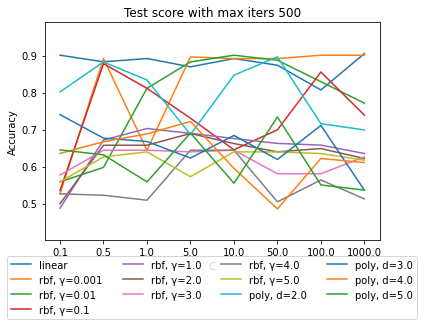

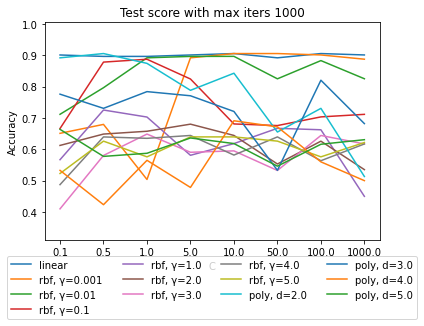

Got best score 0.9055194805194805 with params {'C': 10.0, 'kernel': 'linear', 'max_iters': 1000}
'Choosing best svm' ends in 5min17sec664ms with result {'C': 10.0, 'kernel': 'linear', 'max_iters': 1000}
Got SMO(C=10.0)
starting 'trainig'
'trainig' ends in 3sec330ms with result None
Train score 0.8963963963963963


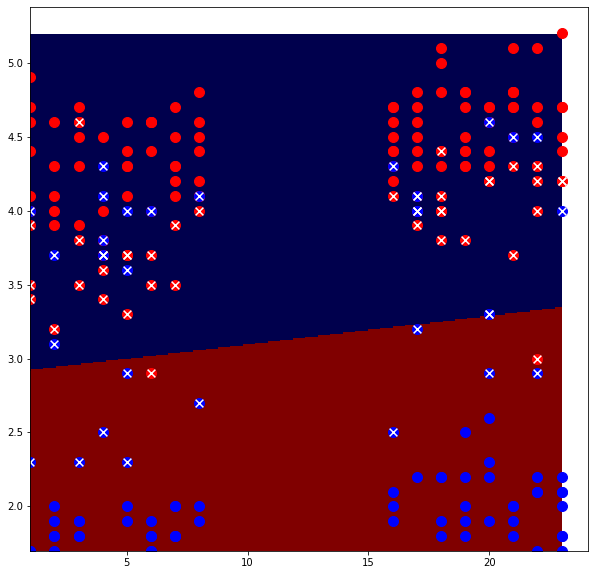

'drawing' ends in 3sec548ms with result None


In [4]:
process('geyser')

starting 'Reading'
'Reading' ends in 2ms with result DataSet[features=2,count=118,test_count=0]
starting 'Choosing best svm'
Fitting 4 folds for each of 208 candidates, totalling 832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:  1.4min finished


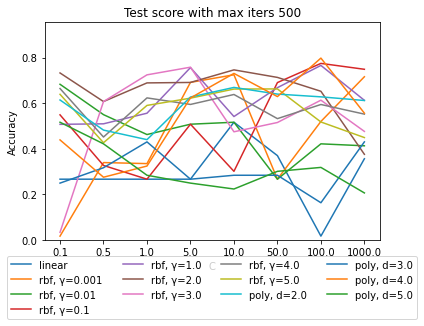

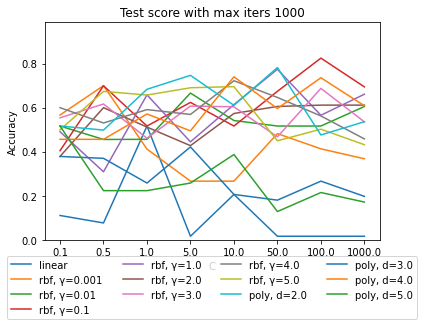

Got best score 0.824712643678161 with params {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf', 'max_iters': 1000}
'Choosing best svm' ends in 1min23sec14ms with result {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf', 'max_iters': 1000}
Got SMO(C=100.0, gamma=0.1, kernel='rbf')
starting 'trainig'
'trainig' ends in 729ms with result None
Train score 0.6610169491525424


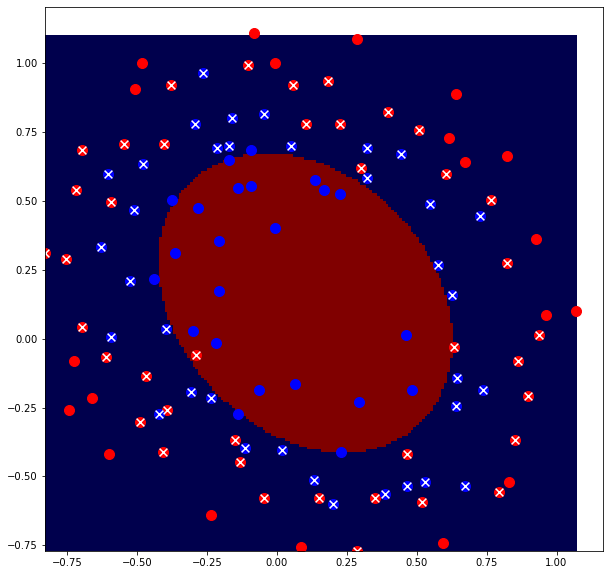

'drawing' ends in 969ms with result None


In [6]:
process('chips')